# Метрические алгоритмы классификации

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import LeaveOneOut

In [2]:
irises = load_iris()
data = irises['data'][:, 2:]
target = irises['target']
target_names = irises['target_names']
colors = np.array(['red', 'green', 'blue', (0, 0, 0, 0)])

## Классификация ирисов Фишера методом KNN

In [3]:
def leaveOneOut(data, target):
    loo = LeaveOneOut()
    errors = [0 for i in range(0, len(data)-1)]
    for train_index, test_index in loo.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]
        for i in range(1, len(data)):
            clf = KNeighborsClassifier(n_neighbors=i)
            clf.fit(X_train, y_train)
            errors[i-1] += (clf.predict(X_test) != y_test)[0] / len(data)
    return errors

In [4]:
n_neighbors = [i for i in range(1,len(data))]
errors = leaveOneOut(data, target)
n = errors.index(min(errors)) + 1
point_of_min = [n, errors[n-1]]

clf = KNeighborsClassifier(n_neighbors=n)
clf.fit(data, target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

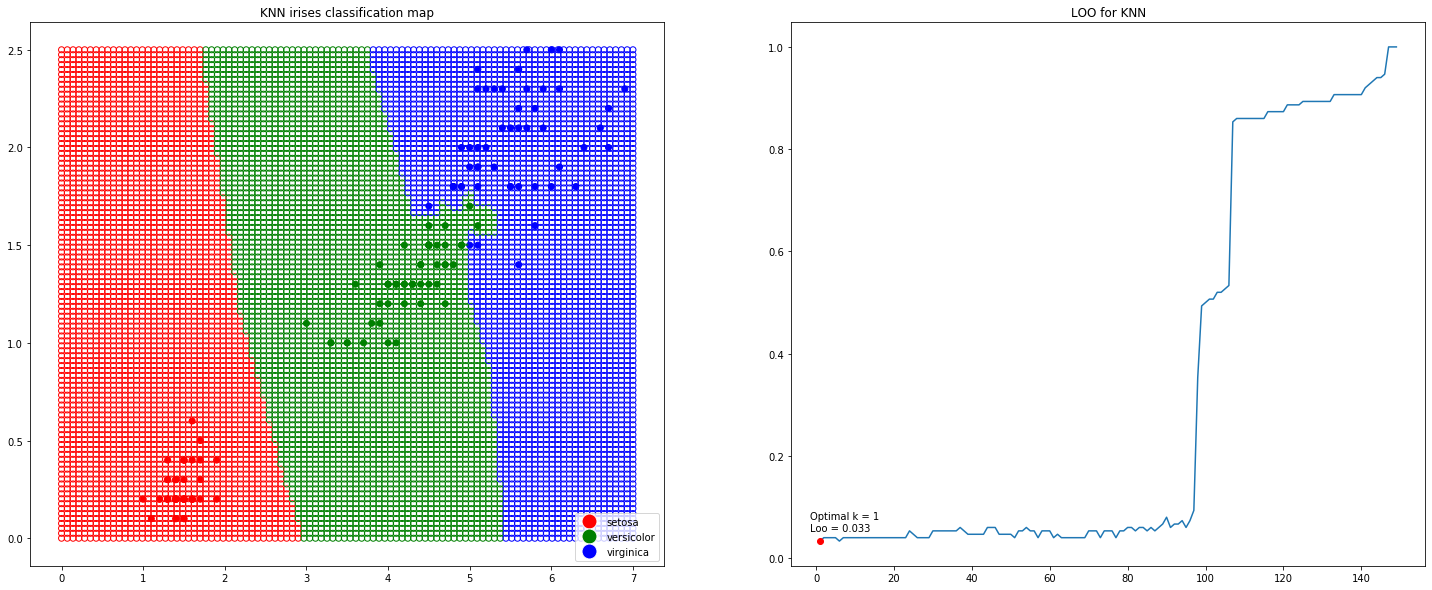

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

x_min, x_max = 0, 7
y_min, y_max = 0, 2.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
ax1.scatter(data[:, 0], data[:, 1], color=colors[target])
handlers = [Line2D([0], [0], marker='o', color='w', label=target_names[i], 
            markerfacecolor=colors[i], markersize=15) for i in range(0, len(target_names))]
ax1.legend(handles=handlers, loc='lower right')
ax1.scatter(xx, yy, edgecolors=colors[Z], facecolors='none')
ax1.set_title('KNN irises classification map')


ax2.plot(n_neighbors, errors)
ax2.plot(point_of_min[0], point_of_min[1], 'or', color='red')
s = 'Optimal k = ' + str(n) + '\nLoo = ' + str(round(errors[n-1], 3))
ax2.annotate(s=s, xy=(point_of_min[0], point_of_min[1]), textcoords='offset points', xytext=(-10, 10))
ax2.set_title('LOO for KNN')

plt.show()

## Классификация ирисов Фишера методом парзеновского окна

In [6]:
def leaveOneOut(data, target, kernel_name):
    loo = LeaveOneOut()
    h = [i for i in np.arange(0.1, 3, 0.1)]
    errors = [0 for i in range(0, len(h))]
    
    for train_index, test_index in loo.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        for i in range(0, len(h)):
            clf = KernelDensity(bandwidth=h[i], kernel=kernel_name)
            errors[i] += (fit_predict(clf, X_test, X_train, y_train) != y_test[0]) / len(data)
    return errors

In [7]:
def fit_predict(clf, obj, data, target):
    splitted_data = [[[]]]
    for i in np.unique(target):
        splitted_data.append(data[np.where(target==i)].tolist())
    splitted_data = splitted_data[1:]
    densities = [np.exp(clf.fit(cls).score(obj)) for cls in splitted_data]
    max_dense = max(densities)
    if max_dense > 0:
        return densities.index(max_dense)
    return 3

In [8]:
def build_classification_map(data, target, clf_kernel):
    errors = leaveOneOut(data, target, clf_kernel)
    h = (errors.index(min(errors)) + 1) / 10
    ind = int(h*10 - 1)
    point_of_min = [h, errors[ind]]
    clf = KernelDensity(bandwidth=h, kernel=clf_kernel)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
    
    x_min, x_max = 0, 7
    y_min, y_max = 0, 2.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    objects = np.c_[xx.ravel(), yy.ravel()]
    Z = [fit_predict(clf, [obj], data, target) for obj in objects]
    ax1.scatter(data[:, 0], data[:, 1], color=colors[target])
    handlers = [Line2D([0], [0], marker='o', color='w', label=target_names[i], 
                markerfacecolor=colors[i], markersize=15) for i in range(0, len(target_names))]
    ax1.legend(handles=handlers, loc='lower right')
    ax1.scatter(xx, yy, edgecolors=colors[Z], facecolors='none')
    ax1.set_title('Parzen window irises classification map')


    ax2.plot(np.arange(0.1, 3, 0.1), errors)
    ax2.plot(point_of_min[0], point_of_min[1], 'or', color='red')
    s = 'Optimal h = ' + str(h) + '\nLoo = ' + str(round(errors[n-1], 3))
    ax2.annotate(s=s, xy=(point_of_min[0], point_of_min[1]), textcoords='offset points', xytext=(-10, 10))
    ax2.set_title('LOO for Parzen window')

    plt.show()

### Классификация с применением прямоугольного ядра

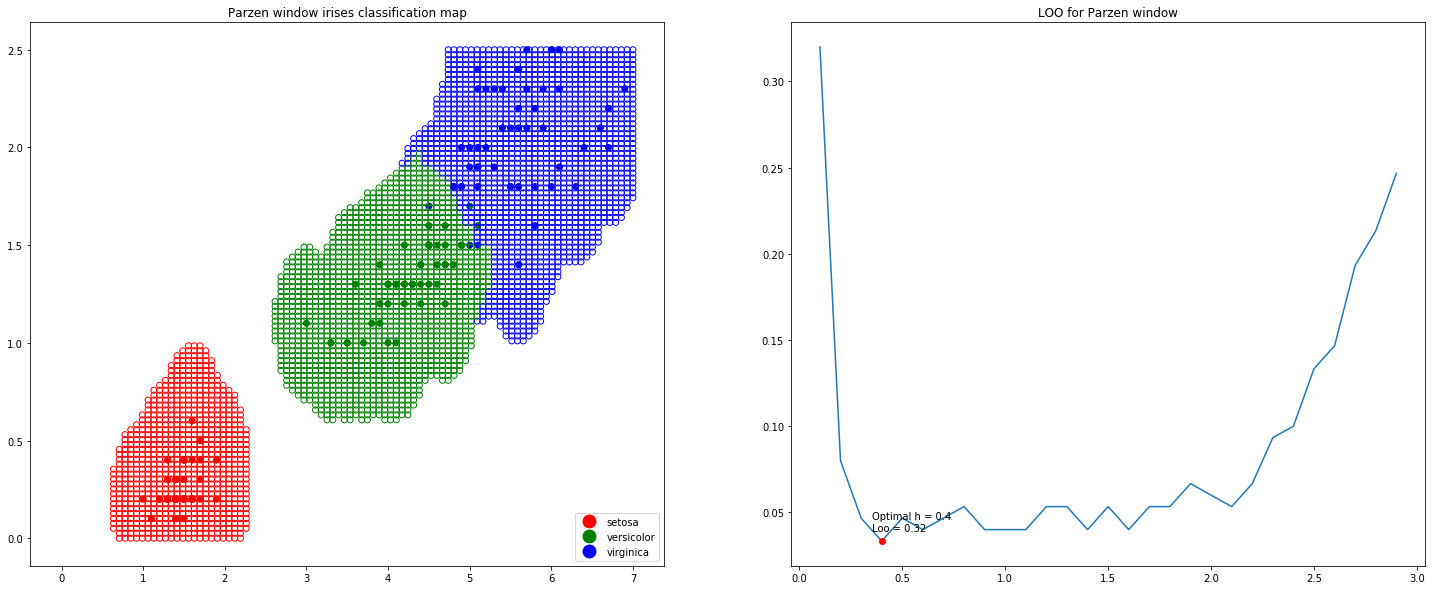

In [9]:
build_classification_map(data, target, 'tophat')

### Классификация с применением ядра Епанечникова

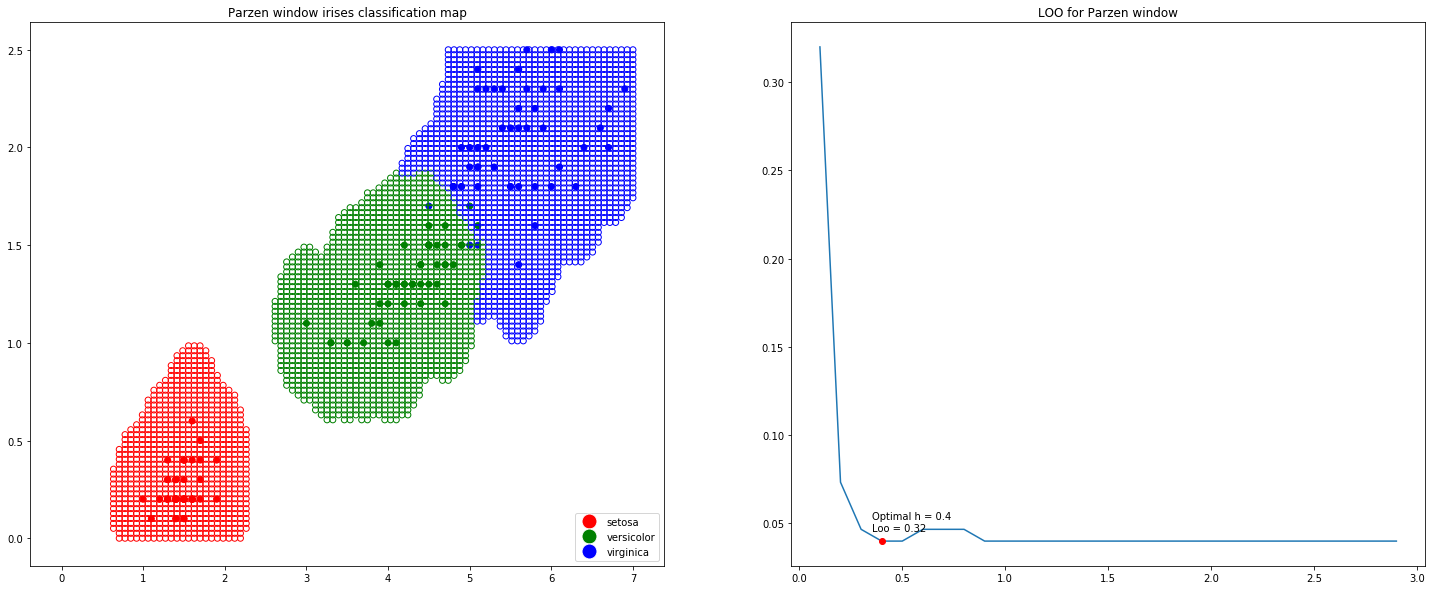

In [10]:
build_classification_map(data, target, 'epanechnikov')

### Классификация с применением Гауссовского ядра

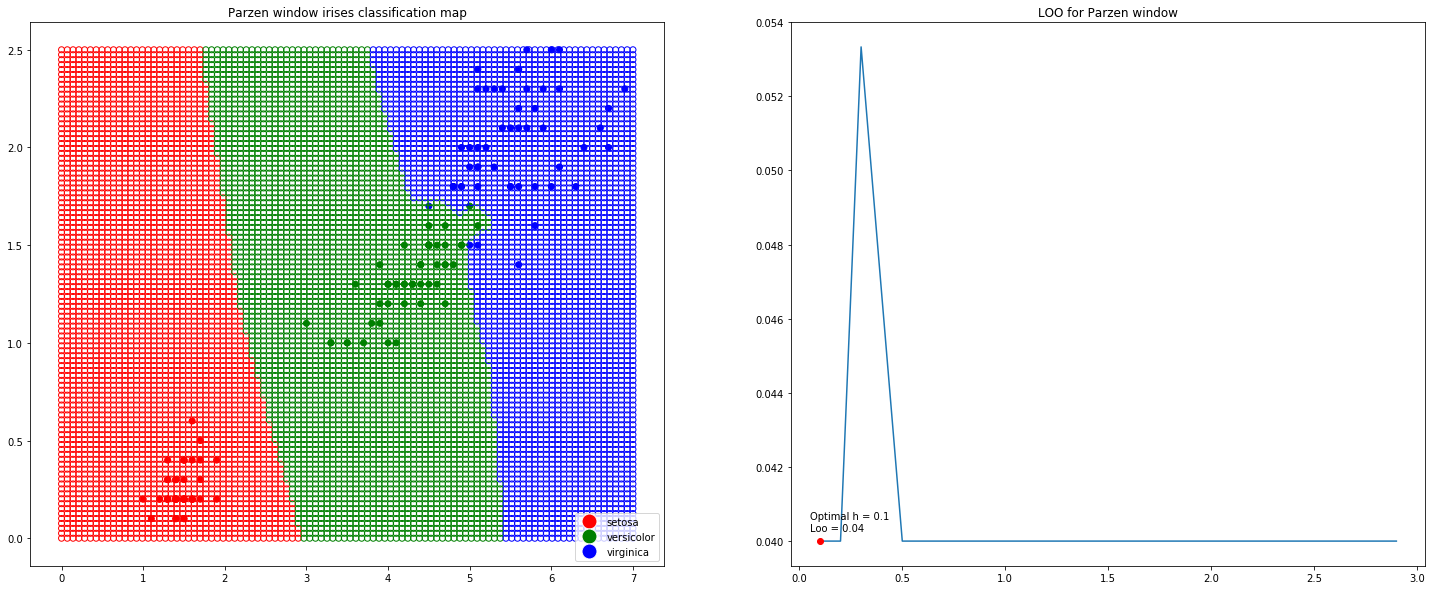

In [11]:
build_classification_map(data, target, 'gaussian')